# Lagged cross-covariance analysis

Resolution: 30-degree latitudinal bands, monthly

---

In [1]:
import sys
sys.path.insert(0, "../src")

In [8]:
import numpy as np
import pandas as pd
import xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import stats 
import data_utils as utils
import plotting as plot

In [3]:
# Define color map with nans set to grey
# cmap = plt.get_cmap("jet")
# cmap.set_bad("grey")

In [4]:
DS_sif = xarray.open_dataset("../data/exp_pro/OCO2_Lite_SIF740.nc")
DS_xco2 = xarray.open_dataset("../data/exp_pro/OCO2_Lite_XCO2_land.nc")

In [5]:
# Cut datasets to latitudinal bands and resample to monthly averages within each band
df_sif_monthly = (
    utils.regrid(DS_sif, res=30)
    .groupby(["lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)
df_xco2_monthly = (
    utils.regrid(DS_xco2, res=30)
    .groupby(["lat"])
    .resample("1MS")
    .mean()
    .drop(columns=["lon", "lat"])
    .reset_index()
)

# Merge dataframes
df_grid_monthly = pd.merge(df_sif_monthly, df_xco2_monthly, on=["lat", "time"], how="outer")
df_grid_monthly

,lat,time,sif,xco2
0,-75.0,2014-09-01,-0.006441,NaN
1,-75.0,2014-10-01,-0.036491,NaN
2,-75.0,2014-11-01,-0.017106,394.021179
3,-75.0,2014-12-01,-0.000255,394.205292
4,-75.0,2015-01-01,0.001039,394.865723
...,...,...,...,...
417,75.0,2020-03-01,0.040242,415.614380
418,75.0,2020-04-01,0.037872,415.644409
419,75.0,2020-05-01,0.054029,414.780121
420,75.0,2020-06-01,0.175329,411.550537


In [6]:
# Convert to dataset and compute statistics
DS_grid_monthly = stats.get_stats(
    df_grid_monthly
    .set_index(["lat", "time"])
    .to_xarray()
    .expand_dims(
        dim={"lon": np.arange(-165, 165+30, 30)}, 
        axis=0
    )
)

DS_grid_monthly["xcor_lag1"] = stats.apply_xcor(DS_grid_monthly.xco2, DS_grid_monthly.sif, lag=1)
DS_grid_monthly["xcor_lag2"] = stats.apply_xcor(DS_grid_monthly.xco2, DS_grid_monthly.sif, lag=2)

DS_grid_monthly

<xarray.Dataset>
Dimensions:     (lat: 6, lon: 12, time: 71)
Coordinates:
  * lon         (lon) int64 -165 -135 -105 -75 -45 -15 15 45 75 105 135 165
  * lat         (lat) float64 -75.0 -45.0 -15.0 15.0 45.0 75.0
  * time        (time) datetime64[ns] 2014-09-01 2014-10-01 ... 2020-07-01
Data variables:
    sif         (lon, lat, time) float32 -0.0064411205 ... 0.21889444
    xco2        (lon, lat, time) float32 nan nan 394.02118 ... 411.55054 407.668
    sif_count   (lon, lat) int64 42 70 70 70 70 52 42 ... 52 42 70 70 70 70 52
    xco2_count  (lon, lat) int64 27 70 70 70 70 53 27 ... 53 27 70 70 70 70 53
    sif_slope   (lon, lat) float64 -1.837e-05 -0.000408 ... 0.0006324 0.0004931
    xco2_slope  (lon, lat) float64 0.2256 0.2085 0.2079 ... 0.2207 0.2173 0.2178
    sif_std     (lon, lat) float64 0.01567 0.02734 0.05726 ... 0.1139 0.06585
    xco2_std    (lon, lat) float64 0.7357 0.4019 0.5914 ... 1.838 2.29 3.56
    xcor_lag1   (lon, lat) float64 0.3715 -0.3923 -0.7331 ... -0.8125 -0.8122
    xcor_lag2   (lon, lat) float64 0.2576 -0.4068 -0.4657 ... -0.9251 -0.6224

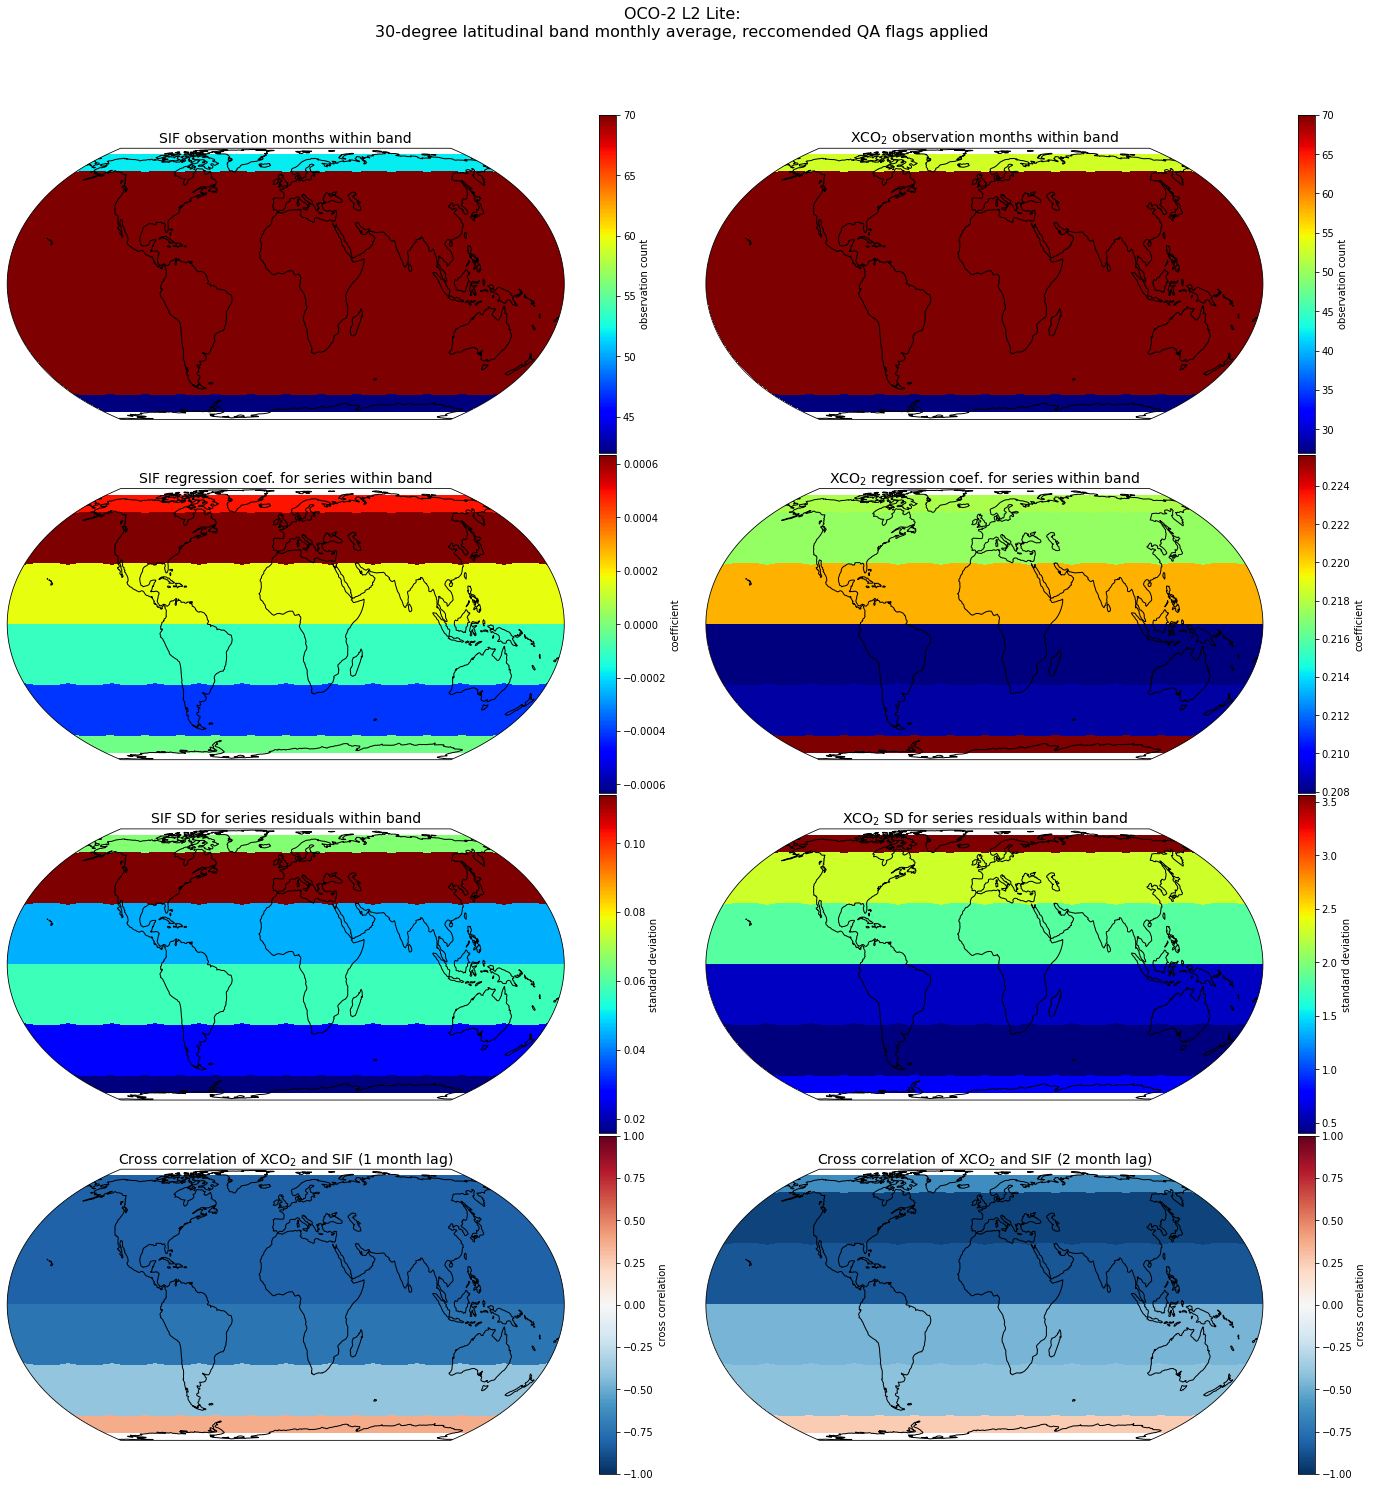

In [11]:
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(100, 100)

# fig.subplots_adjust(top=0.8)
fig.suptitle(
    "OCO-2 L2 Lite:\n"
    "30-degree latitudinal band monthly average, reccomended QA flags applied",
    size=16, y=0.94
)

# Counts
ax1 = fig.add_subplot(gs[:25, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:25, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.sif_count,
    title="SIF observation months within band",
    ax=ax1,
    cbar_kwargs={"label": "observation count"},
    robust=False
)
plot.plot_da(
    DS_grid_monthly.xco2_count,
    title="XCO$_2$ observation months within band",
    ax=ax2,
    cbar_kwargs={"label": "observation count"},
    robust=False
)

# Slopes
ax3 = fig.add_subplot(gs[25:50, 0:50], projection=ccrs.EqualEarth())
ax4 = fig.add_subplot(gs[25:50, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.sif_slope,
    title="SIF regression coef. for series within band",
    ax=ax3,
    cbar_kwargs={"label": "coefficient"}
)
plot.plot_da(
    DS_grid_monthly.xco2_slope,
    title="XCO$_2$ regression coef. for series within band",
    ax=ax4,
    cbar_kwargs={"label": "coefficient"}
)

# Standard deviation
ax5 = fig.add_subplot(gs[50:75, 0:50], projection=ccrs.EqualEarth())
ax6 = fig.add_subplot(gs[50:75, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.sif_std,
    title="SIF SD for series residuals within band",
    ax=ax5,
    cbar_kwargs={"label": "standard deviation"}
)
plot.plot_da(
    DS_grid_monthly.xco2_std,
    title="XCO$_2$ SD for series residuals within band",
    ax=ax6,
    cbar_kwargs={"label": "standard deviation"}
)

# Cross correlation
ax7 = fig.add_subplot(gs[75:, 0:50], projection=ccrs.EqualEarth())
ax8 = fig.add_subplot(gs[75:, 50:], projection=ccrs.EqualEarth())
plot.plot_da(
    DS_grid_monthly.xcor_lag1,
    title="Cross correlation of XCO$_2$ and SIF (1 month lag)",
    ax=ax7,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)
plot.plot_da(
    DS_grid_monthly.xcor_lag2,
    title="Cross correlation of XCO$_2$ and SIF (2 month lag)",
    ax=ax8,
    vmin=-1, vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={"label": "cross correlation"}
)

fig.savefig("../plots/30deg-band_monthly_panel.png");